<a href="https://colab.research.google.com/github/soujh/NLP_OpenFoodFacts/blob/main/NLP_openFF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gdown  https://drive.google.com/uc?id=183LHYJjd1t3JJ6n1lWJM6tnsjw6Nnx7X

Downloading...
From: https://drive.google.com/uc?id=183LHYJjd1t3JJ6n1lWJM6tnsjw6Nnx7X
To: /content/100000-products.csv.zip
100% 31.6M/31.6M [00:00<00:00, 147MB/s]


In [ ]:
!unzip /content/100000-products.csv.zip

Archive:  /content/100000-products.csv.zip
  inflating: 100000-products.csv     


In [ ]:
import numpy as np , matplotlib as plt 
%pylab inline
from scipy import stats
from scipy.stats import chi2_contingency

import pandas as pd
%matplotlib inline
import seaborn as sns


import nltk
from sklearn import neighbors
import random

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
df=pd.read_csv("/content/100000-products.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (67) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df.shape

(100000, 188)

On visualise les 10 premières lignes

In [ ]:
df.head(10)

,Unnamed: 0,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,quantity,packaging,packaging_tags,packaging_text,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,origins_en,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,...,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,334803,0244860307835,http://world-en.openfoodfacts.org/product/0244...,tacinte,1421808570,2015-01-21T02:49:30Z,1550520553,2019-02-18T20:09:13Z,Natural Pork Boneless Pork Loin Chops,NaN,NaN,NaN,plastic,plastic,NaN,Trader Joe's,trader-joe-s,"Meats, Pork","en:meats,en:pork","Meats,Pork",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Trader Joe's,United States,en:united-states,United States,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0176,NaN,0.000952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1692996,80321606,http://world-en.openfoodfacts.org/product/8032...,kiliweb,1574656150,2019-11-25T04:29:10Z,1616314659,2021-03-21T08:17:39Z,Allen joghurt,NaN,NaN,NaN,NaN,NaN,NaN,Sterzing Vipiteno,sterzing-vipiteno,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:de,en:germany,Germany,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1392859,5400742903082,http://world-en.openfoodfacts.org/product/5400...,kiliweb,1625822705,2021-07-09T09:25:05Z,1625822706,2021-07-09T09:25:06Z,Saumon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:be,en:belgium,Belgium,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,667232,2600280022761,http://world-en.openfoodfacts.org/product/2600...,kiliweb,1615651443,2021-03-13T16:04:03Z,1615651446,2021-03-13T16:04:06Z,Confiserie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:fr,en:france,France,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,537282,18739565,http://world-en.openfoodfacts.org/product/1873...,kiliweb,1635504712,2021-10-29T10:51:52Z,1635505424,2021-10-29T11:03:44Z,Barrita cereales,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hacendado,en:es,en:spain,Spain,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1035628,3700191000045,http://world-en.openfoodfacts.org/product/3700...,kiliweb,1519678414,2018-02-26T20:53:34Z,1519736691,2018-02-27T13:04:51Z,La Saïada Thon entier a l’huile,NaN,NaN,NaN,NaN,NaN,NaN,La Saïada,la-saiada,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F

In [ ]:
df.describe()

,Unnamed: 0,created_t,last_modified_t,cities,allergens_en,serving_quantity,no_nutriments,additives_n,additives,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,nutriscore_score,nova_group,ecoscore_score_fr,energy-kj_100g,energy-kcal_100g,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,-palmitic-acid_100g,-stearic-acid_100g,-arachidic-acid_100g,-behenic-acid_100g,-lignoceric-acid_100g,-cerotic-acid_100g,-montanic-acid_100g,-melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,...,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
count,1.000000e+05,1.000000e+05,1.000000e+05,0.0,0.0,24731.000000,0.0,35919.000000,0.0,35919.000000,0.0,35919.000000,0.0,35814.000000,31257.000000,1.0,7241.000000,7.673600e+04,7.926800e+04,51.000000,78879.000000,76787.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2367.000000,2364.000000,87.000000,0.0,...,6.560000e+02,59.000000,304.000000,4.000000,15.000000,4524.000000,36.000000,13339.000000,694.000000,13016.000000,733.000000,515.000000,226.000000,216.000000,18.000000,1.310000e+02,8.000000,13.000000,115.000000,22.000000,6.000000,13.000000,467.000000,36.000000,607.000000,35835.000000,20.00000,296.000000,0.0,23.000000,589.000000,35814.000000,0.0,0.0,0.0,3.000000,87.000000,1.0,3.000000,1.0000
mean,1.006580e+06,1.561065e+09,1.596086e+09,NaN,NaN,181.279150,NaN,2.023525,NaN,0.021187,NaN,0.070074,NaN,9.112945,3.429504,34.0,1092.387584,3.409420e+02,1.414095e+03,407.658824,13.997640,5.116348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.235609,5.938073,4.357456,NaN,...,2.710802e-02,0.134249,2.638570,0.056728,23.227216,0.637717,0.897964,0.215990,0.725569,0.023776,1.012154,0.060038,0.002016,0.009875,0.004569,1.132843e-04,0.050074,3.176951,0.267636,0.532680,0.146583,6.435538,33.306094,6.151278,47.127000,8.438505,14.84000,53.171115,NaN,224.391304,528.905382,9.112945,NaN,NaN,NaN,0.060033,0.000242,4.0,0.034000,0.0073
std,5.798780e+05,5.307282e+07,3.158337e+07,NaN,NaN,7269.178722,NaN,2.886561,NaN,0.145163,NaN,0.304239,NaN,8.830746,0.968054,NaN,874.356310,1.721726e+04,7.087734e+04,653.136011,41.708819,10.328543,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.283530,10.101291,9.881446,NaN,...,5.540574e-01,0.976860,45.882775,0.095674,67.037763,10.665033,4.567217,7.102312,8.712010,1.189715,18.748459,0.984694,0.019925,0.125110,0.010604,9.590723e-04,0.141392,9.249688,2.704841,1.207803,0.197099,1.992094,36.241977,23.178957,28.868255,23.481633,4.84566,21.806759,NaN,317.257100,755.876515,8.830746,NaN,NaN,NaN,0.045123,0.001165,NaN,0.040841,NaN
min,0.000000e+00,1.328973e+09,1.333873e+09,NaN,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,-14.000000,1.000000,34.0,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,...,0.000000e+00,0.000000,0.000000,0.001912,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000e-07,0.000002,0.000000,0.000000,0.007900,0.000000,0.322000,0.000000,0.000000,0.0

Ici l'on observe les features ayant plus ou moins de valeurs manquantes. On remarque bien que certaines colonnes ont très ou pas de données

Text(0.5, 0, 'percentage')

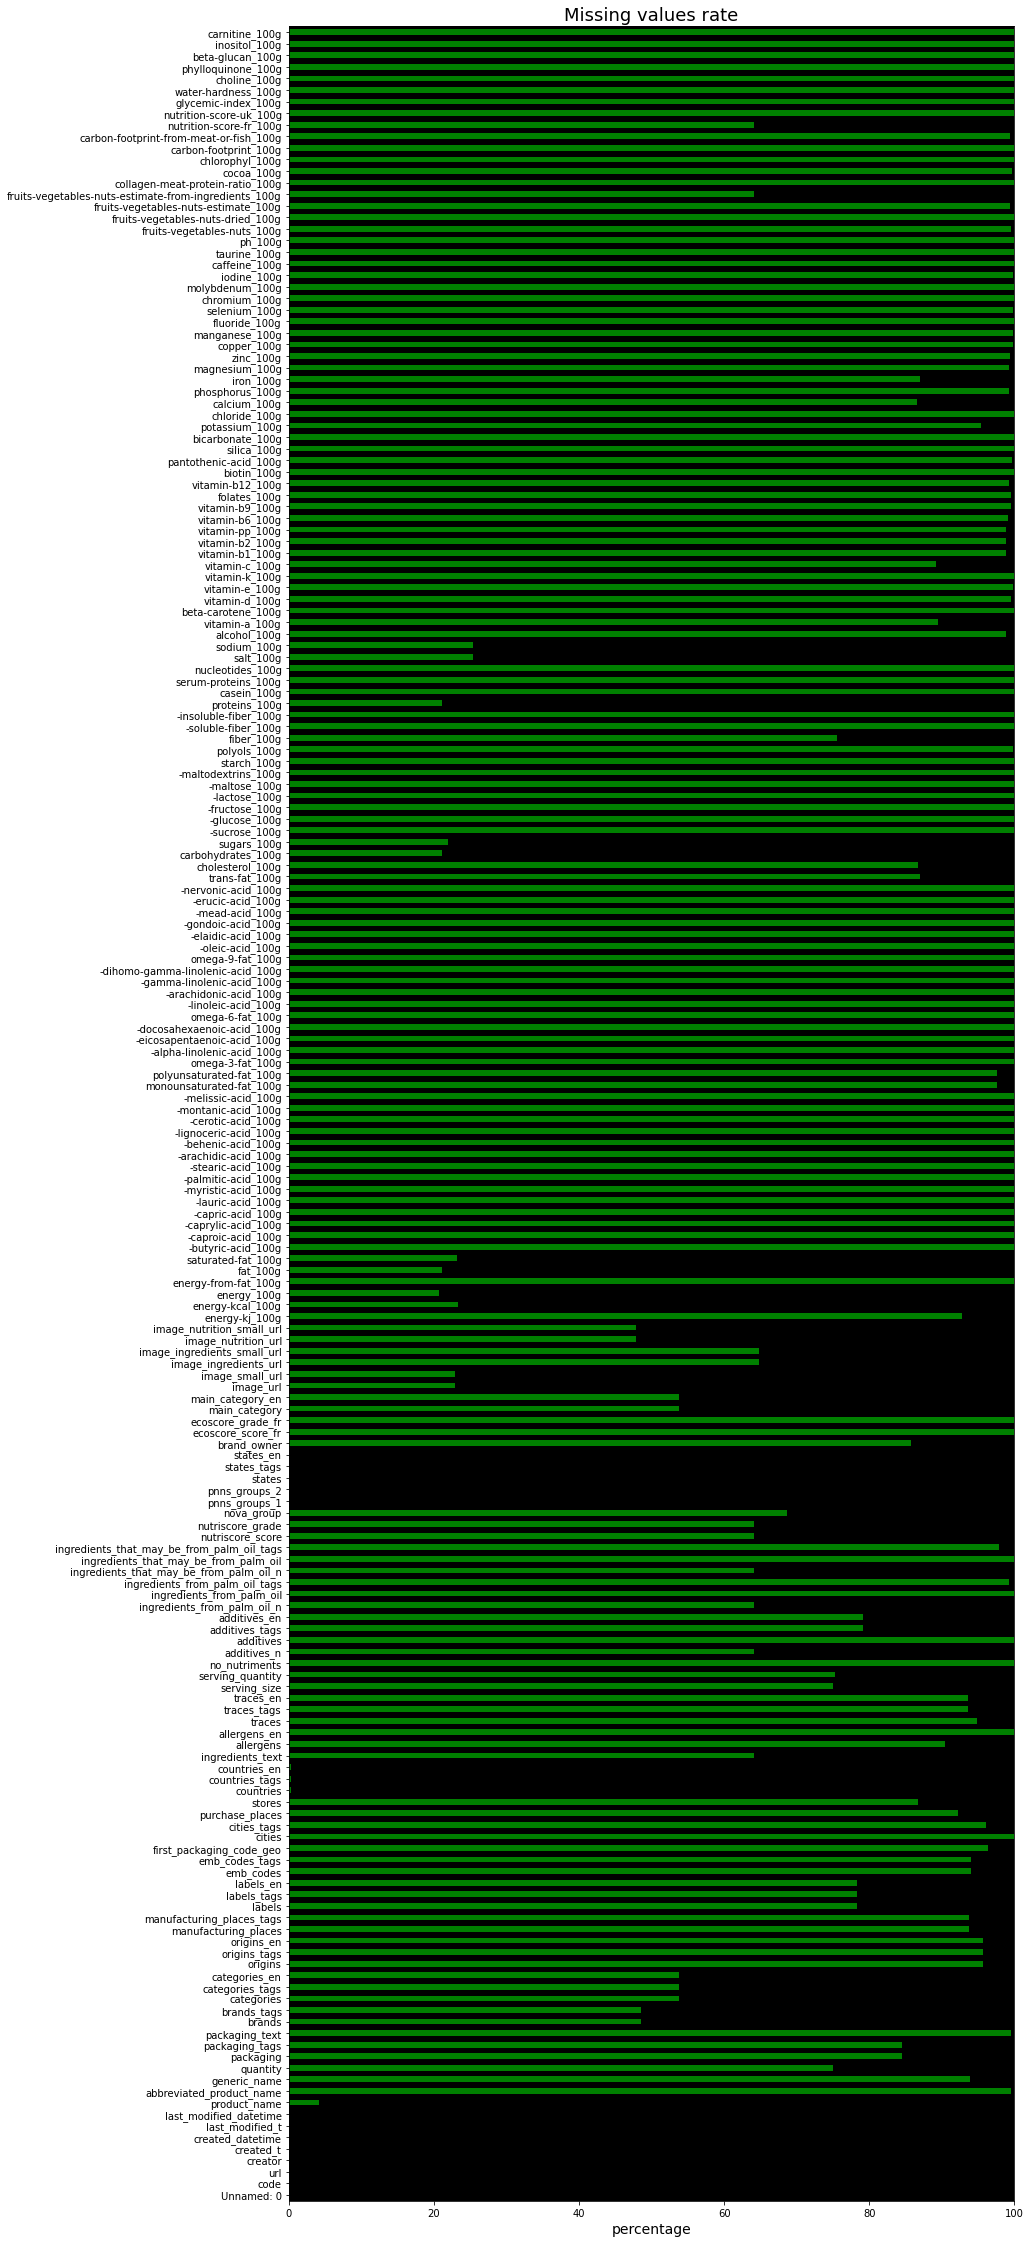

In [ ]:
plt.figure(figsize=(13, 40))
plt.rcParams['axes.facecolor'] = 'black'
plt.rc('grid', color='#202020')
(df.isnull().mean(axis=0)*100).plot.barh(color ="green")
plt.xlim(xmax=100)
plt.title("Missing values rate",fontsize=18)
plt.xlabel("percentage",fontsize=14)

##Exercie 1 

On se concentre sur la colonne ingrédients_text, l'idée est de netoyer la colonne pour ensuite faire une petite études sur les ingrédients. (Afficher les plus rededonants etc

In [ ]:
#Commençons par drop les nan de la colonnnes
df=df.dropna(subset=["ingredients_text"])

In [ ]:
df.loc[:,"ingredients_text"] .isnull().mean(axis=0)*100


0.0

In [ ]:
df.loc[:50,"ingredients_text"] 
# On affiche les ingredients jusqu'à l'index 50

12    Sugar, whey, cocoa (processed with alkali), co...
13          Aroniabeeren (90 %), Zucker, Sonnenblumenöl
15    Farine de blé 42%, pépites de chocolat au lait...
18    Chicken, bacon (pork, water, salt, sugar, sodi...
21    Gemüsemischung in veränderlichen Gewichtsantei...
22    Gemüsemischung (82%) (Zucchini, Zwiebeln, rote...
23    16665 sk dansk Smør, Min, 80% fedt, INGREDIENS...
24    sucre, jus de fruits à base de concentrés : 29...
26    Levure bio, farine dorge maltée bio, se\ de me...
28    мука пшеничная, масло растительное, сахар, раз...
31    Farine de blé, sucre, huiles végétales (palme,...
39    MIEL DE MEL DE ESPANYA MIEL DE L'ESPAGNE Infor...
40    Eau, sucre, sirop de glucose séché, concentré ...
43    Pâte 41,1% (farine de blé (contient _gluten_),...
45    Potatoes, water, all-purpose flour, pecorino r...
49    Milano salami (pork, salt and less than 2% of ...
Name: ingredients_text, dtype: object

In [ ]:
df=df.reset_index()

Nous remarquons plusieurs langues différentes dans la colonne "ingrédients names"

In [ ]:
df['ingredients_text']=df['ingredients_text'].replace({'eau': 'water','sel': 'salt','sucre':'sugar','huile':"oil","farine":"flour","lait":"milk"})


On décide de remplacer les différents ingrédients en français et de les mettre en anglais

In [ ]:
#remove special charachters
#remove empty words
spec_chars = ["!",'"',"#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–"]
for char in spec_chars:
    df['ingredients_text'] = df['ingredients_text'].str.replace(char, ' ')

On efface les caractères spéciaux de la liste des ingredients car ils ne sont d'aucune utilité

In [ ]:
#tolower 
df['ingredients_text'] = df['ingredients_text'].str.lower()

Ici l'on met tous les caractères en minuscule pour ne pas qu'il y ait de perte d'informations lors du comptage

In [ ]:
#Remove numbers 
import re
for i in range(len(df)):
  df["ingredients_text"][i]=text_nonum = re.sub(r'\d+', '', df["ingredients_text"][i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
###Tokenzisation

Ici on Tokenize par rapport au espace contenu entre les mots

In [ ]:
from nltk.tokenize import TreebankWordTokenizer
tokenizer = TreebankWordTokenizer()

In [ ]:
for i in range(len(df)):
  df["ingredients_text"][i]=tokenizer.tokenize(df["ingredients_text"][i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stops_en=set(stopwords.words('english'))
stops_fr=set(stopwords.words('french'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Ici on a effacé tous les stopwords qui ne sont pas utiles et qui parasytent l'information ex : "à" "d'" "de"

In [ ]:
###StopWords
stops=set.union(stops_en,stops_fr)

In [ ]:
for i in range(len(df)):
  words=df["ingredients_text"][i]
  df["ingredients_text"][i]=[word for word in words if word not in stops]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Ici le tokinzer tokenize par phrase, on cherche plus à tokenizer par mots. Pour ca on décide de supprimer tout les "." dans notre chaine de caractère. 

In [ ]:
type(df["ingredients_text"][51])

list

In [ ]:
final=[]
for i in range(len(df)):
  for j in range(len(df["ingredients_text"][i])):
    final.append(df["ingredients_text"][i][j])

In [ ]:
from collections import Counter

In [ ]:
dict_counter=Counter(final).most_common()

Ici l'on compte les termes par leur apparation et on les classe dans l'odre décroissant

In [ ]:
dict_counter

[('salt', 18560),
 ('sugar', 13731),
 ('oil', 13420),
 ('acid', 12958),
 ('water', 10959),
 ('sodium', 10633),
 ('flour', 10503),
 ('milk', 10269),
 ('e', 9422),
 ('natural', 9227),
 ('sel', 9202),
 ('corn', 8970),
 ('organic', 8527),
 ('wheat', 8149),
 ('sucre', 7865),
 ('lait', 7454),
 ('flavor', 6537),
 ('powder', 6494),
 ('eau', 6351),
 ('syrup', 5837),
 ('soy', 5684),
 ('starch', 5606),
 ('gum', 5345),
 ('citric', 5038),
 ('huile', 4995),
 ('poudre', 4951),
 ('vitamin', 4913),
 ('blé', 4881),
 ('farine', 4750),
 ('color', 4560),
 ('contains', 4377),
 ('cheese', 4371),
 ('lecithin', 4080),
 ('cacao', 4074),
 ('juice', 4008),
 ('garlic', 3990),
 ('b', 3917),
 ('extract', 3899),
 ('dextrose', 3894),
 ('calcium', 3882),
 ('potassium', 3838),
 ('artificial', 3790),
 ('palm', 3715),
 ('less', 3676),
 ('cocoa', 3601),
 ('red', 3576),
 ('arôme', 3551),
 ('soybean', 3549),
 ('acide', 3363),
 ('soja', 3275),
 ('butter', 3173),
 ('flavors', 3104),
 ('vegetable', 3073),
 ('g', 3068),
 ('modif

In [ ]:
count_ing = pd.DataFrame(dict_counter)

In [ ]:
count_ing

,0,1
0,salt,18560
1,sugar,13731
2,oil,13420
3,acid,12958
4,water,10959
...,...,...
56772,tetragonoloba,1
56773,fibregumtm,1
56774,vinitroxtm,1
56775,stévol,1


In [ ]:
top_20=count_ing.nlargest(20,1)

In [ ]:
type(top_20)

pandas.core.frame.DataFrame

Top 20 des ingrédients les plus présents

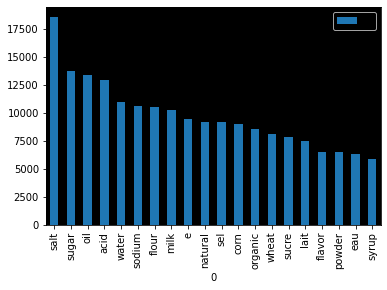

In [ ]:
top_20.plot.bar(0,1)

In [ ]:
from wordcloud import WordCloud

In [ ]:
wc=WordCloud()

#Exercice 2

On cherche a clusterizer suivant les apports nutritif 

On sépare le dataset en train et en test

In [ ]:
from sklearn.model_selection import train_test_split

train_table, test_table = train_test_split(df, test_size=0.3, random_state=0)

In [ ]:
train_table.shape


(21690, 189)

In [ ]:
test_table.shape

(9297, 189)

Voici les features qui nous intéressent de conserver

In [ ]:
features = ["carbohydrates_100g",
            "fat_100g",
            "proteins_100g",
            "sugars_100g",
            "salt_100g",
            "energy_100g",]

In [ ]:
X_train = train_table[features].values
X_test = test_table[features].values

In [ ]:
df=df.dropna(subset=features)

On utilise un GMM pour clusteriser => Gaussian Mixture Model

In [ ]:
from sklearn.mixture import GaussianMixture
components = 20
model = GaussianMixture(n_components=components,
                        covariance_type="full",
                        random_state=1,
                        n_init=1,
                        max_iter=200,
                        init_params="kmeans")
model.fit(X_train)

print("Model converged: " + str(model.converged_))


Model converged: True


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


Graphique présentant le pourcentage de data suivant le nombre cluster qui ont été determinés par le GNN

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


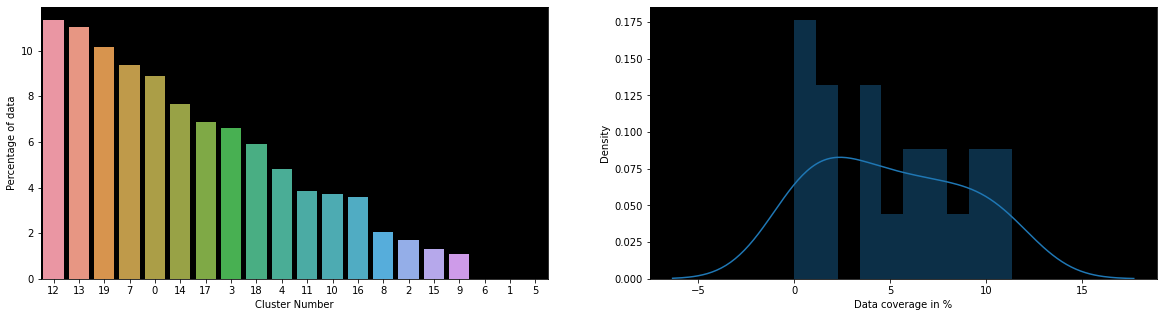

In [ ]:
#Nombre de data par cluster
cluster_count = train_table.cluster.value_counts()

fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.barplot(x=cluster_count.index,
            y=cluster_count.values / train_table.shape[0] * 100,
            order=cluster_count.index, ax=ax[0])
ax[0].set_xlabel("Cluster Number")
ax[0].set_ylabel("Percentage of data")
sns.distplot(cluster_count.values / train_table.shape[0] * 100, bins=10, ax=ax[1])
ax[1].set_xlabel("Data coverage in %")
ax[1].set_ylabel("Density");

In [ ]:
train_table.shape[0]

21690

In [ ]:
#Affichage du cluster 10, le plus gros en taille, on remarque que c'est globalement des produits plutot calorique. 

test_table[test_table["cluster"]==10][["product_name"]] 

,product_name
23020,Low-In-Carb Wraps
11249,Dark Chocolate
22626,Krit
6807,"Peanut butter chocolate performance bar, peanu..."
8508,White wine cream sauce
...,...
12199,Thai Satay Sauce
14999,Confiture de lait
26753,Confit D'oignon Au Miel Et Aux Epices
22712,Pain au lait
